# Exploratory Data Analysis and Clustering Patterns of Penguin Data

## Loading Libraries

In [12]:
import csv,sqlite3

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import levene, shapiro
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from scipy.stats import kruskal, mannwhitneyu
from scipy.stats import f_oneway
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [14]:
import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [15]:
df = pd.read_csv('Penguin.csv')

df.head()

,Unnamed: 0,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


ignoring the first column

In [16]:
df = df.iloc[:, 1:]
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


## Check for missing values

In [17]:
# Check for missing values
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

In [18]:
# Drop rows with missing values
df = df.dropna()

In [19]:
# Verify no missing values
df.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
year                 0
dtype: int64

## Convert DataFrame to SQLite Database

In [20]:
con = sqlite3.connect("Penguins.db")
cur = con.cursor()

In [21]:
df.to_sql("PENGUINS", con, if_exists='replace', index=False,method="multi")

333

In [22]:
df = pd.read_sql("select * from PENGUINS",con)
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


## Basic EDA using SQL queries

### Count of unique species


In [23]:
query1 = """
SELECT species, COUNT(*) as count
FROM PENGUINS
GROUP BY species;
"""

# Execute the queries
species_count = pd.read_sql_query(query1, con)

species_count

,species,count
0,Adelie,146
1,Chinstrap,68
2,Gentoo,119


### Count of unique islands


In [24]:
query2 = """
SELECT island, COUNT(*) as count
FROM PENGUINS
GROUP BY island;
"""

island_count = pd.read_sql_query(query2, con)
island_count

,island,count
0,Biscoe,163
1,Dream,123
2,Torgersen,47


### Count of gender

In [25]:
query3 = """
SELECT sex, COUNT(*) as count
FROM PENGUINS
GROUP BY sex;
"""

# Execute the queries
gender_count = pd.read_sql_query(query3, con)

gender_count

,sex,count
0,female,165
1,male,168


### Count of year

In [26]:
query4 = """
SELECT year, COUNT(*) as count
FROM PENGUINS
GROUP BY year;
"""

# Execute the queries
year_count = pd.read_sql_query(query4, con)

year_count

,year,count
0,2007,103
1,2008,113
2,2009,117


### Count of records by island and species


In [27]:
query_count_by_island_species = """
                                 SELECT 
                                     island,
                                     species,
                                     COUNT(*) AS count
                                 FROM 
                                     PENGUINS
                                 GROUP BY 
                                     island, species;
                                 """
df_count_by_island_species = pd.read_sql(query_count_by_island_species, con)

# Display the DataFrame
df_count_by_island_species

,island,species,count
0,Biscoe,Adelie,44
1,Biscoe,Gentoo,119
2,Dream,Adelie,55
3,Dream,Chinstrap,68
4,Torgersen,Adelie,47


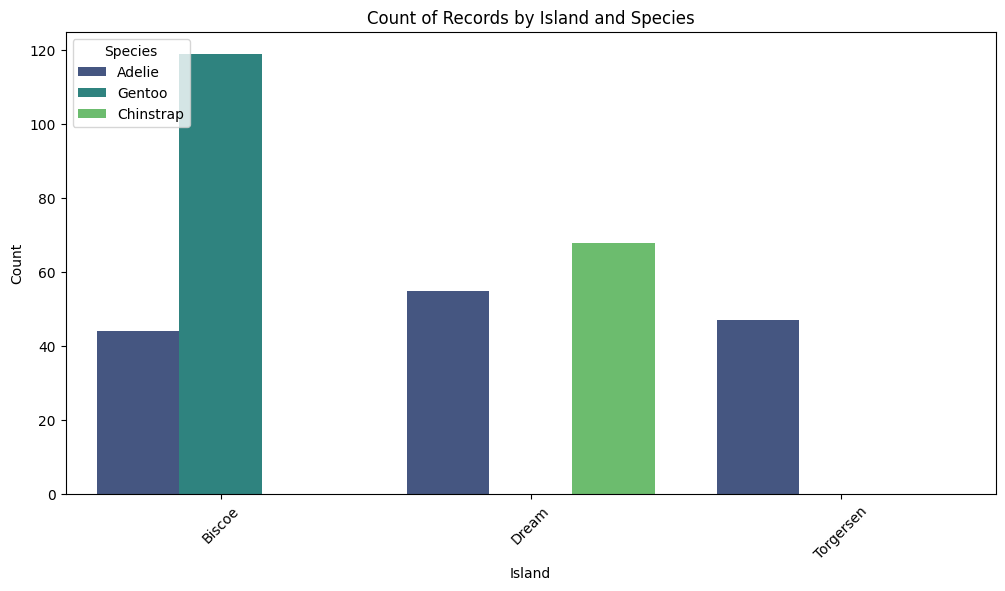

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_count_by_island_species, x='island', y='count', hue='species', palette='viridis')
plt.title('Count of Records by Island and Species')
plt.xlabel('Island')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Species')
plt.show()

### Gender distribution


In [29]:
query_gender_distribution = """
                             SELECT 
                                 sex,
                                 COUNT(*) AS count
                             FROM 
                                 PENGUINS
                             GROUP BY 
                                 sex;
                             """
df_gender_distribution = pd.read_sql(query_gender_distribution, con)

# Display the DataFrame
df_gender_distribution

,sex,count
0,female,165
1,male,168


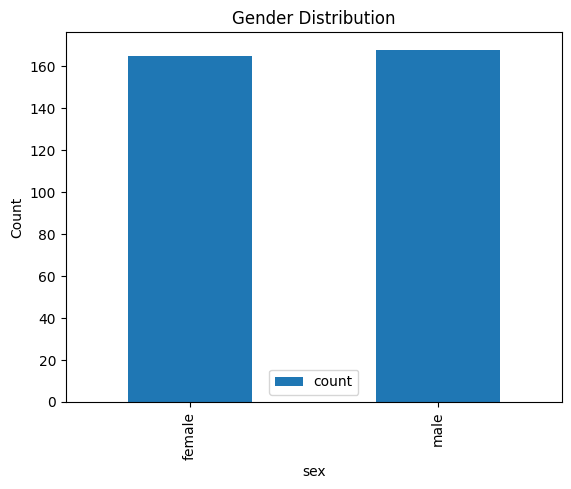

In [30]:
df_gender_distribution.plot(kind="bar", x="sex", ylabel="Count", title="Gender Distribution")
plt.show()

### Temporal analysis


In [31]:
query_temporal_analysis = """
                          SELECT 
                              year,
                              COUNT(*) AS count
                          FROM 
                              PENGUINS
                          GROUP BY 
                              year
                          ORDER BY 
                              year;
                          """
df_temporal_analysis = pd.read_sql(query_temporal_analysis, con)

# Display the DataFrame
df_temporal_analysis

,year,count
0,2007,103
1,2008,113
2,2009,117


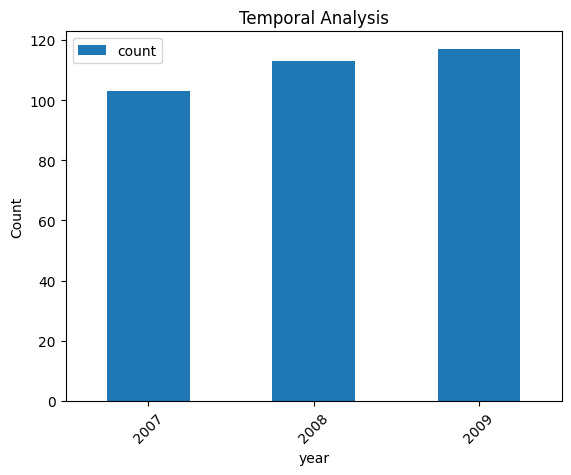

In [32]:
# Plotting Temporal analysis
df_temporal_analysis.plot(kind="bar", x="year", ylabel="Count", title="Temporal Analysis")
plt.xticks(rotation=45)
plt.show()

### Variates across Categorical Variables

In [33]:
species_analysis = pd.read_sql_query("""
SELECT species, AVG(bill_length_mm) as avg_bill_length, AVG(bill_depth_mm) as avg_bill_depth, 
       AVG(flipper_length_mm) as avg_flipper_length, AVG(body_mass_g) as avg_body_mass
FROM PENGUINS
GROUP BY species;
""", con)
species_analysis

,species,avg_bill_length,avg_bill_depth,avg_flipper_length,avg_body_mass
0,Adelie,38.823973,18.347260,190.102740,3706.164384
1,Chinstrap,48.833824,18.420588,195.823529,3733.088235
2,Gentoo,47.568067,14.996639,217.235294,5092.436975


In [34]:
gender_analysis = pd.read_sql_query("""
SELECT sex, AVG(bill_length_mm) as avg_bill_length, AVG(bill_depth_mm) as avg_bill_depth, 
       AVG(flipper_length_mm) as avg_flipper_length, AVG(body_mass_g) as avg_body_mass
FROM PENGUINS
GROUP BY sex;
""", con)
gender_analysis

,sex,avg_bill_length,avg_bill_depth,avg_flipper_length,avg_body_mass
0,female,42.096970,16.425455,197.363636,3862.272727
1,male,45.854762,17.891071,204.505952,4545.684524


In [35]:
island_analysis = pd.read_sql_query("""
SELECT island, AVG(bill_length_mm) as avg_bill_length, AVG(bill_depth_mm) as avg_bill_depth, 
       AVG(flipper_length_mm) as avg_flipper_length, AVG(body_mass_g) as avg_body_mass
FROM PENGUINS
GROUP BY island;
""", con)
island_analysis

,island,avg_bill_length,avg_bill_depth,avg_flipper_length,avg_body_mass
0,Biscoe,45.248466,15.907362,209.558282,4719.171779
1,Dream,44.221951,18.339837,193.186992,3718.902439
2,Torgersen,39.038298,18.451064,191.531915,3708.510638


### Body Mass by Year


In [36]:
query_year_body_mass = """
                        SELECT 
                            year,
                            body_mass_g
                        FROM 
                            PENGUINS;
                        """
df_year_body_mass = pd.read_sql(query_year_body_mass, con)
df_year_body_mass

,year,body_mass_g
0,2007,3750.0
1,2007,3800.0
2,2007,3250.0
3,2007,3450.0
4,2007,3650.0
...,...,...
328,2009,4000.0
329,2009,3400.0
330,2009,3775.0
331,2009,4100.0


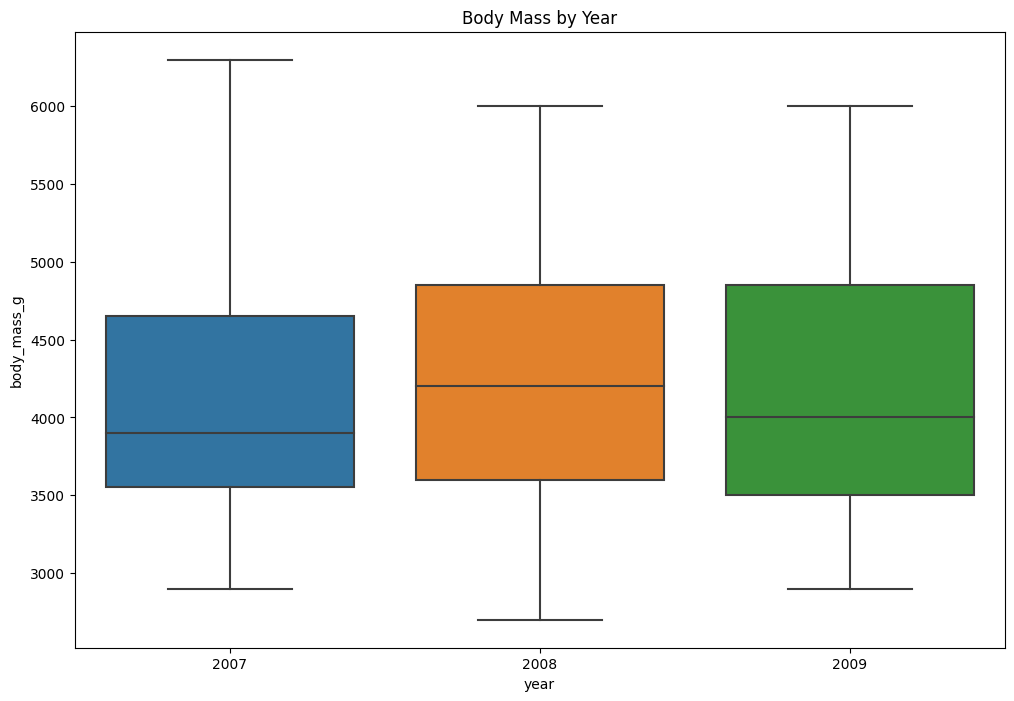

In [37]:
# Visualizations
plt.figure(figsize=(12, 8))
sns.boxplot(x='year', y='body_mass_g', data=df_year_body_mass)
plt.title('Body Mass by Year')
plt.show()

### Body Mass by Gender

In [38]:
query_sex_body_mass = """
                        SELECT 
                            sex,
                            body_mass_g
                        FROM 
                            PENGUINS;
                        """
df_sex_body_mass = pd.read_sql(query_sex_body_mass, con)
df_sex_body_mass

,sex,body_mass_g
0,male,3750.0
1,female,3800.0
2,female,3250.0
3,female,3450.0
4,male,3650.0
...,...,...
328,male,4000.0
329,female,3400.0
330,male,3775.0
331,male,4100.0


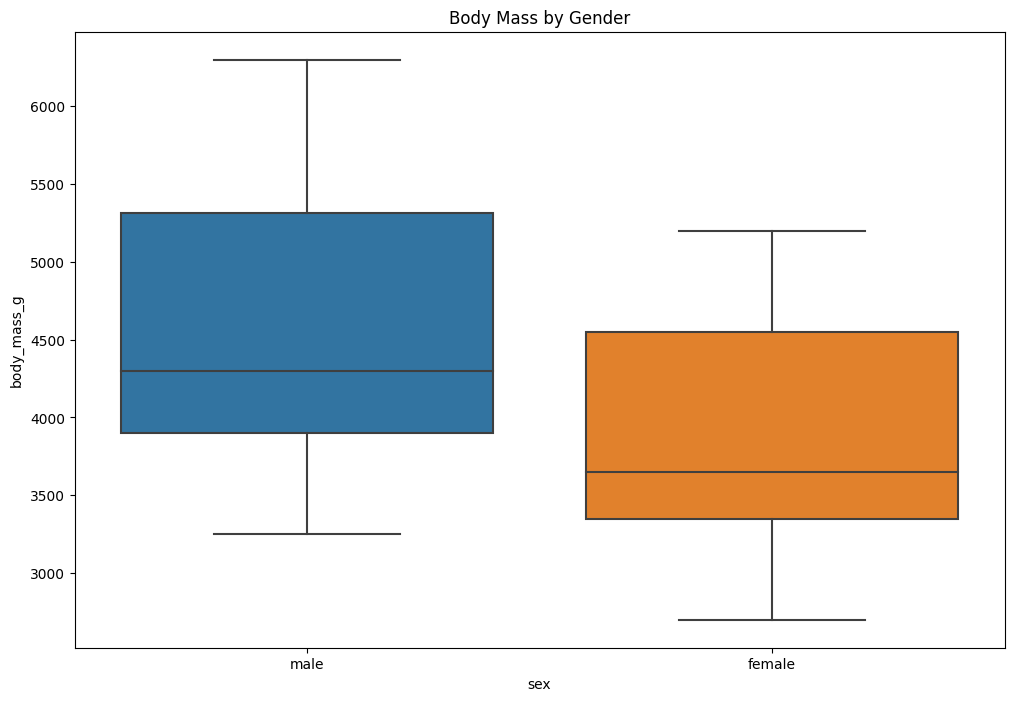

In [39]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='sex', y='body_mass_g', data=df_sex_body_mass)
plt.title('Body Mass by Gender')
plt.show()

### Body Mass by Island

In [40]:
query_island_body_mass = """
                            SELECT 
                                island,
                                body_mass_g
                            FROM 
                                PENGUINS;
                            """
df_island_body_mass = pd.read_sql(query_island_body_mass, con)
df_island_body_mass

,island,body_mass_g
0,Torgersen,3750.0
1,Torgersen,3800.0
2,Torgersen,3250.0
3,Torgersen,3450.0
4,Torgersen,3650.0
...,...,...
328,Dream,4000.0
329,Dream,3400.0
330,Dream,3775.0
331,Dream,4100.0


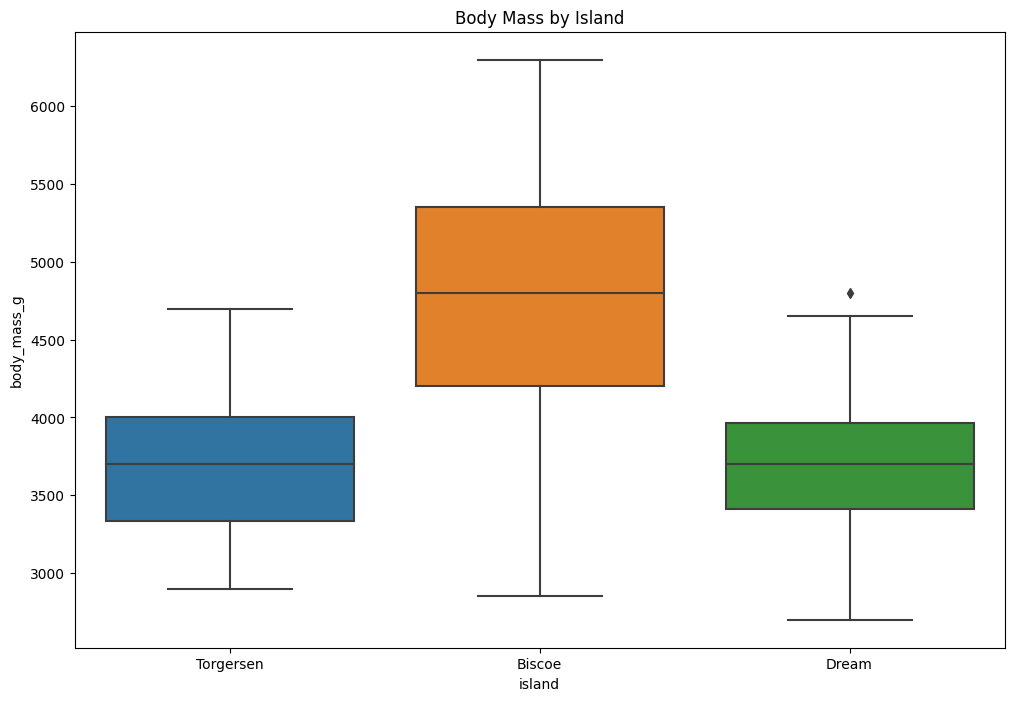

In [41]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='island', y='body_mass_g', data=df_island_body_mass)
plt.title('Body Mass by Island')
plt.show()

## Descriptive Analysis

In [42]:
# Descriptive statistics
desc_stats = df.groupby(['year', 'sex', 'island']).describe()
desc_stats

bill_length_mm                                     \
                               count       mean       std   min     25%   
year sex    island                                                        
2007 female Biscoe              21.0  43.257143  3.909677  35.3  40.900   
            Dream               22.0  43.004545  5.361190  36.0  38.075   
            Torgersen            8.0  38.275000  2.218590  34.4  36.675   
     male   Biscoe              22.0  46.763636  5.026837  37.7  46.150   
            Dream               23.0  46.313043  5.531176  37.2  40.850   
            Torgersen            7.0  39.900000  3.541186  34.6  38.850   
2008 female Biscoe              31.0  42.783871  4.331289  34.5  39.300   
            Dream               17.0  41.423529  5.547469  33.1  36.900   
            Torgersen            8.0  36.612500  2.477578  33.5  35.275   
     male   Biscoe              32.0  46.350000  4.172491  37.6  41.900   
            Dream               17.0  46.088235  6.110225  36.3  40.800   
            Torgersen            8.0  40.925000  3.435841  35.1  39.075   
2009 female Biscoe              28.0  43.925000  4.264463  35.0  39.675   
            Dream               22.0  42.263636  5.844863  32.1  36.850   
            Torgersen            8.0  37.775000  1.814820  35.2  36.075   
     male   Biscoe              29.0  48.237931  4.913859  37.8  45.600   
            Dream               22.0  45.931818  6.003284  37.5  40.300   
            Torgersen            8.0  40.850000  2.360387  37.3  39.875   

                                           bill_depth_mm             ...  \
                         50%     75%   max         count       mean  ...   
year sex    island                                                   ...   
2007 female Biscoe     45.10  46.100  48.7          21.0  15.085714  ...   
            Dream      44.20  46.325  58.0          22.0  17.840909  ...   
            Torgersen  38.80  39.700  41.1           8.0  18.162500  ...   
     male   Biscoe     47.70  49.275  59.6          22.0  16.031818  ...   
            Dream      49.20  51.300  52.7          23.0  19.260870  ...   
            Torgersen  39.20  40.900  46.0           7.0  20.485714  ...   
2008 female Biscoe     44.00  45.750  49.1          31.0  15.029032  ...   
            Dream      40.90  46.400  50.5          17.0  17.529412  ...   
            Torgersen  36.05  37.425  40.9           8.0  17.400000  ...   
     male   Biscoe     47.30  49.650  54.3          32.0  16.640625  ...   
            Dream      49.00  51.000  54.2          17.0  19.264706  ...   
            Torgersen  41.95  42.825  45.8           8.0  18.837500  ...   
2009 female Biscoe     45.05  47.250  50.5          28.0  15.450000  ...   
            Dream      43.00  46.525  50.9          22.0  17.418182  ...   
            Torgersen  38.55  38.850  40.2           8.0  17.087500  ...   
     male   Biscoe     49.80  51.300  55.9          29.0  16.979310  ...   
            Dream      49.15  50.800  55.8          22.0  18.709091  ...   
            Torgersen  41.25  41.900  44.1           8.0  18.987500  ...   

                      flipper_length_mm        body_mass_g               \
                                    75%    max       count         mean   
year sex    island                                                        
2007 female Biscoe               211.00  215.0        21.0  4345.238095   
            Dream                191.50  198.0        22.0  3446.590909   
            Torgersen            193.50  195.0         8.0  3475.000000   
     male   Biscoe               219.75  230.0        22.0  5147.727273   
            Dream                197.00  201.0        23.0  3942.391304   
            Torgersen            196.00  198.0         7.0  4139.285714   
2008 female Biscoe               215.50  220.0        31.0  4225.806452   
            Dream                195.00  202.0        17.0  3444.117647   
            Torgersen   

Considering the category combination 'year = 2007', 'sex = female', 'island = Biscoe':

- For 'bill_length_mm', the mean is approximately 21.0 mm, with a standard deviation of about 43.26 mm. The minimum bill length observed is 3.91 mm, and the maximum is 48.7 mm.
- For 'body_mass_g', the mean body mass is approximately 4345.24 grams, with a standard deviation of around 570.72 grams. The minimum body mass observed is 3150 grams, and the maximum is 5050 grams.

## Impact of Body Mass by Year, Gender, and Island

We aim to investigate the potential influence of various factors, namely `year`, `gender`, and `island`, on the variable `body_mass_g`. The analysis seeks to determine whether these factors independently impact `body_mass_g` and whether there exists an interplay among them.

To assess the potential influence of each factor on `body_mass_g`, we plan to employ statistical techniques such as ANOVA (Analysis of Variance) and t-tests. 

- **ANOVA** will allow us to determine if there are significant differences in `body_mass_g` across different `years` and `islands`
- **T-tests** will facilitate a comparison of mean `body_mass_g` between `genders`. 

Significant findings from these tests will provide insights into whether `year`, `gender`, or `island` individually affects `body_mass_g`.

### Check assumptions for ANOVA

#### Homogeneity of Variance

Levene's Test for body_mass_g by year:
  Statistic=0.43590551929238713, p-value=0.6470506309803156


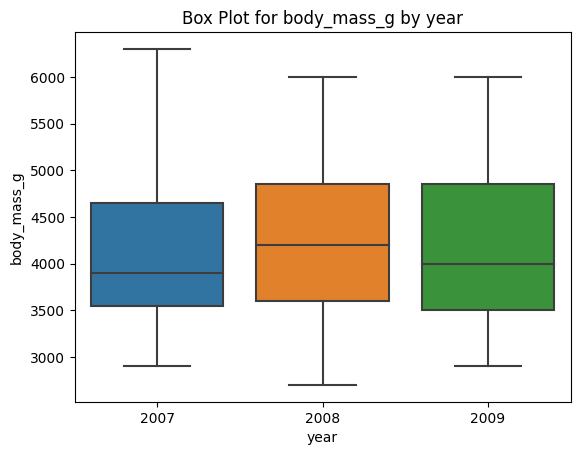

Levene's Test for body_mass_g by sex:
  Statistic=6.058617438712248, p-value=0.014348206700435228


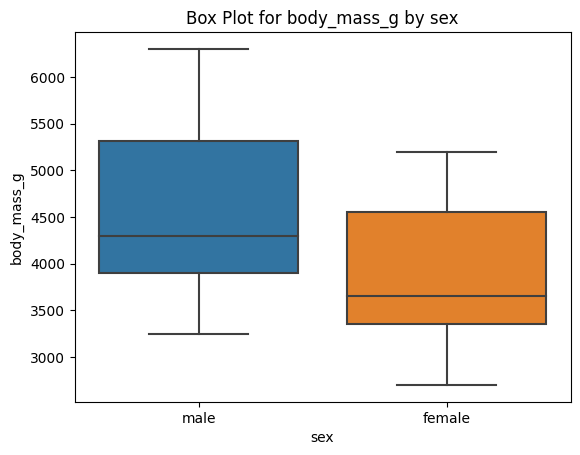

Levene's Test for body_mass_g by island:
  Statistic=25.96880750906024, p-value=3.357753610567291e-11


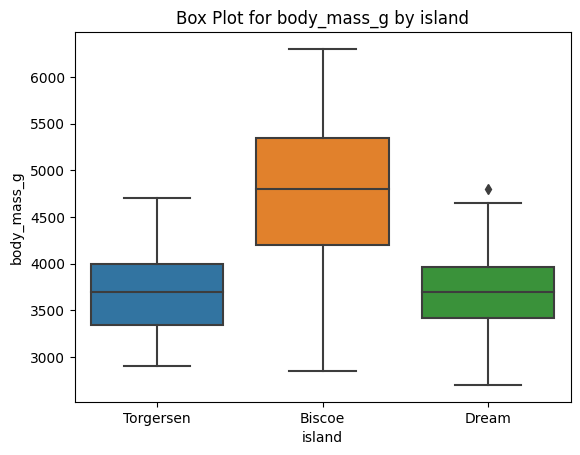

In [49]:
# Check Homogeneity of Variance
def check_homogeneity(data, group_column, target_column='body_mass_g'):
    groups = [data[target_column][data[group_column] == category].dropna() for category in data[group_column].unique()]

    # Perform Levene's test
    levene_test_result = levene(*groups)

    # Display the result
    print(f"Levene's Test for {target_column} by {group_column}:")
    print(f"  Statistic={levene_test_result.statistic}, p-value={levene_test_result.pvalue}")

    # Box plot
    plt.figure()
    sns.boxplot(x=group_column, y=target_column, data=data)
    plt.title(f'Box Plot for {target_column} by {group_column}')
    plt.show()

# Check assumptions
check_homogeneity(df, 'year')
check_homogeneity(df, 'sex')
check_homogeneity(df, 'island')

**Methodology:**
Levene's test was utilized to examine the equality of variances (homogeneity) for `body_mass_g` across the groups defined by the categorical variables `year`, `sex`, and `island`. Box plots were also generated for visual inspection.

**Results:**

- **Levene's Test for `body_mass_g` by `year`:**
  - Statistic: 0.4359
  - p-value: 0.6471

- **Levene's Test for `body_mass_g` by `sex`:**
  - Statistic: 6.0586
  - p-value: 0.0143

- **Levene's Test for `body_mass_g` by `island`:**
  - Statistic: 25.9688
  - p-value: 3.3578e-11

**Interpretation:**

- **Year**:
  - The p-value (0.6471) is greater than 0.05, indicating that we fail to reject the null hypothesis. Therefore, the variances of `body_mass_g` across different years are homogeneous.
- **Sex**:
  - The p-value (0.0143) is less than 0.05, indicating that we reject the null hypothesis. Therefore, the variances of `body_mass_g` between sexes are not homogeneous.
- **Island**:
  - The p-value (3.3578e-11) is much less than 0.05, indicating that we reject the null hypothesis. Therefore, the variances of `body_mass_g` across different islands are not homogeneous.

#### Normality

In [56]:
# Function to perform Shapiro-Wilk test and plot Q-Q plot
def check_normality(data, columns):
    col_data = data[columns].dropna()

    # Perform Shapiro-Wilk test
    shapiro_test_result = shapiro(col_data)

    # Display the result
    print(f"Shapiro-Wilk Test for {columns}:")
    print(f"  Statistic={shapiro_test_result.statistic}, p-value={shapiro_test_result.pvalue}")

    # Q-Q plot
    plt.figure()
    stats.probplot(col_data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {columns}')
    plt.show()

Shapiro-Wilk Test for bill_length_mm:
  Statistic=0.9743415117263794, p-value=1.190045804833062e-05


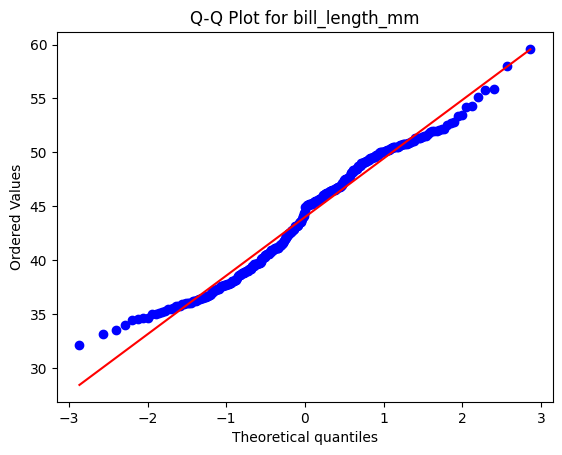

In [57]:
check_normality(df, 'bill_length_mm')

**Methodology:**
The Shapiro-Wilk test was employed to evaluate whether the distribution of each numerical variable deviates significantly from a normal distribution. Additionally, Q-Q plots were generated to visually inspect the normality of the data.

**Results:**

- **bill_length_mm:**
  - Statistic: 0.9743
  - p-value: 1.1900e-05

**Interpretation:**
The Shapiro-Wilk test p-value for `bill_length_mm` is significantly less than the threshold of 0.05. Hence, we reject the null hypothesis that `bill_length_mm` is normally distributed. The Q-Q plot (not shown here) also indicates deviations from normality.

Use the Mann-Whitney U test for comparing body mass between male and female groups due to the violation of normality assumption in gender groups.

Use ANOVA for comparing body mass among different islands and years, as assumptions of homogeneity of variance and normality are met for these groups.

In [50]:
# Perform ANOVA
def perform_anova(data):
    model = ols('body_mass_g ~ C(year) + C(sex) + C(island)', data=data).fit()
    anova_table = anova_lm(model, typ=2)
    print(anova_table)

    # Interaction effects
    interaction_model = ols('body_mass_g ~ C(year) * C(sex) * C(island)', data=data).fit()
    interaction_anova_table = anova_lm(interaction_model, typ=2)
    print(interaction_anova_table)
    
    
# Perform ANOVA
perform_anova(df)

                 sum_sq     df           F        PR(>F)
C(year)    5.004977e+04    2.0    0.087396  9.163360e-01
C(sex)     3.783262e+07    1.0  132.124564  6.524023e-26
C(island)  8.208244e+07    2.0  143.330089  2.006037e-45
Residual   9.363337e+07  327.0         NaN           NaN
                                sum_sq     df           F        PR(>F)
C(year)                   5.095059e+04    2.0    0.089091  9.147858e-01
C(sex)                    3.789429e+07    1.0  132.521420  7.838636e-26
C(island)                 8.208920e+07    2.0  143.538498  4.883338e-45
C(year):C(sex)            1.062658e+05    2.0    0.185813  8.305199e-01
C(year):C(island)         2.277300e+06    4.0    1.991007  9.569587e-02
C(sex):C(island)          9.858138e+05    2.0    1.723762  1.800722e-01
C(year):C(sex):C(island)  1.175871e+05    4.0    0.102804  9.814615e-01
Residual                  9.007374e+07  315.0         NaN           NaN


In [62]:
# Kruskal-Wallis H Test for 'body_mass_g' across 'year'
groups = [df['body_mass_g'][df['year'] == year].dropna() for year in df['year'].unique()]
kruskal_result_year = kruskal(*groups)
print("Kruskal-Wallis H Test for body_mass_g by year:")
print(kruskal_result_year)

# Kruskal-Wallis H Test for 'body_mass_g' across 'island'
groups = [df['body_mass_g'][df['island'] == island].dropna() for island in df['island'].unique()]
kruskal_result_island = kruskal(*groups)
print("\nKruskal-Wallis H Test for body_mass_g by island:")
print(kruskal_result_island)

# Mann-Whitney U Test for 'body_mass_g' across 'sex'
male_body_mass = df['body_mass_g'][df['sex'] == 'male'].dropna()
female_body_mass = df['body_mass_g'][df['sex'] == 'female'].dropna()
mannwhitney_result_sex = mannwhitneyu(male_body_mass, female_body_mass)
print("\nMann-Whitney U Test for body_mass_g by sex:")
print(mannwhitney_result_sex)

Kruskal-Wallis H Test for body_mass_g by year:
KruskalResult(statistic=1.6950192835069529, pvalue=0.4284806747390647)

Kruskal-Wallis H Test for body_mass_g by island:
KruskalResult(statistic=124.35211300028672, pvalue=9.937605573673624e-28)

Mann-Whitney U Test for body_mass_g by sex:
MannwhitneyuResult(statistic=20845.5, pvalue=1.8133343032461057e-15)


### Interpretation

#### Kruskal-Wallis H Test for `body_mass_g` by `year`
- **Statistic**: 1.6950
- **p-value**: 0.4285

**Interpretation**:
- The p-value (0.4285) is greater than the common significance threshold of 0.05.
- This indicates that there is no statistically significant difference in `body_mass_g` across different years.
- Therefore, the year does not appear to have a significant impact on `body_mass_g`.

#### Kruskal-Wallis H Test for `body_mass_g` by `island`
- **Statistic**: 124.3521
- **p-value**: 9.9376e-28

**Interpretation**:
- The p-value (9.9376e-28) is much smaller than 0.05, indicating a highly statistically significant difference in `body_mass_g` across different islands.
- This suggests that the island on which the penguins are located has a significant effect on their body mass.

#### Mann-Whitney U Test for `body_mass_g` by `sex`
- **Statistic**: 20845.5
- **p-value**: 1.8133e-15

**Interpretation**:
- The p-value (1.8133e-15) is much smaller than 0.05, indicating a highly statistically significant difference in `body_mass_g` between male and female penguins.
- This suggests that the sex of the penguins significantly affects their body mass.

#### Summary of Findings

Based on the results from the Kruskal-Wallis H Test and Mann-Whitney U Test:

1. **Year**: There is no significant effect of the year on `body_mass_g` (p-value = 0.4285).
2. **Island**: There is a significant effect of the island on `body_mass_g` (p-value = 9.9376e-28).
3. **Sex**: There is a significant effect of sex on `body_mass_g` (p-value = 1.8133e-15).

#### Conclusion

- The island and sex of the penguins are significant factors influencing `body_mass_g`.
- There is no evidence to suggest that the year has a significant impact on `body_mass_g`.

## Clustering Patterns and K-Means Algorithm

### Clustering Patterns by Year

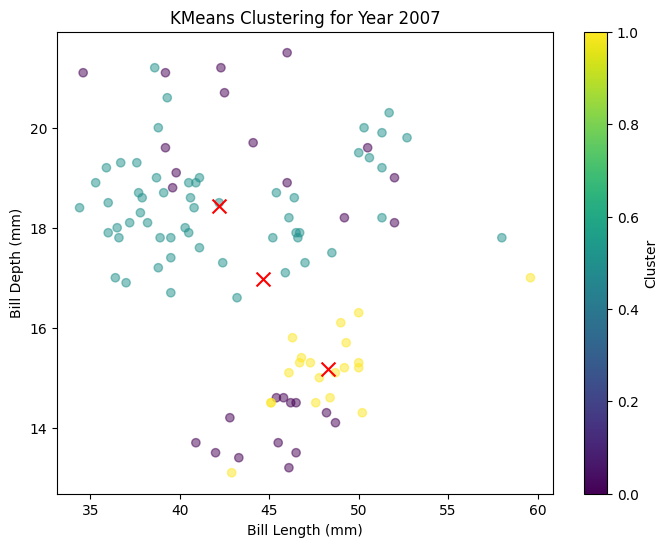

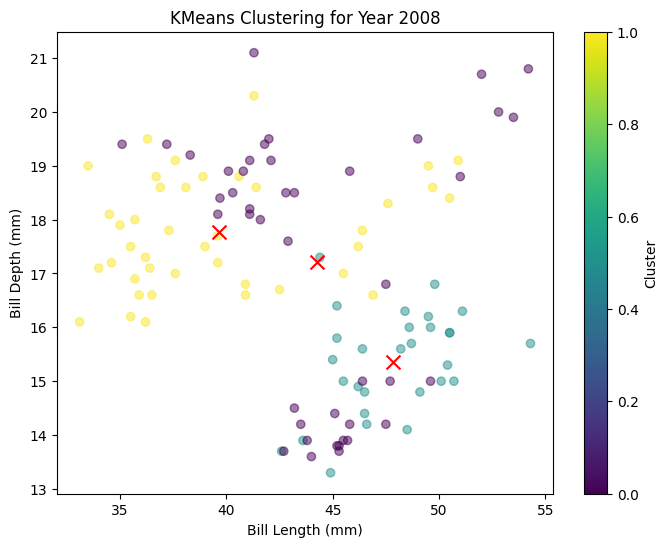

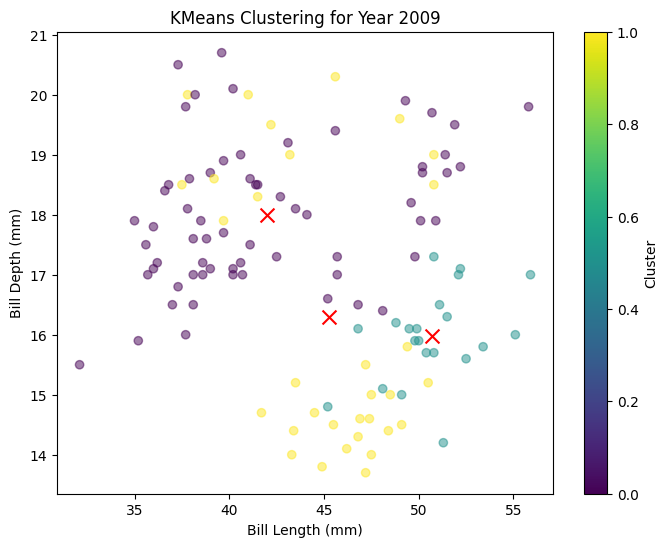

In [66]:
from sklearn.cluster import KMeans
import pandas as pd

# KMeans clustering
kmeans_clusters = []  # List to store cluster labels
for year in df['year'].unique():
    data_year = df[df['year'] == year][['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
    kmeans = KMeans(n_clusters=3, random_state=42).fit(data_year)
    kmeans_clusters.extend(kmeans.labels_)  # Add cluster labels for this year
    labels = kmeans.labels_
    
    # Visualize clusters - assuming only two predicto variables for visualization purposes
    plt.figure(figsize=(8, 6))
    plt.scatter(data_year['bill_length_mm'], data_year['bill_depth_mm'], c=labels, cmap='viridis', alpha=0.5)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
    plt.title(f'KMeans Clustering for Year {year}')
    plt.xlabel('Bill Length (mm)')
    plt.ylabel('Bill Depth (mm)')
    plt.colorbar(label='Cluster')
    plt.show()

In [67]:
# Add cluster labels to the DataFrame
df['Cluster'] = kmeans_clusters

df.sample(8)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,Cluster
96,Adelie,Biscoe,37.7,16.0,183.0,3075.0,female,2009,0
242,Gentoo,Biscoe,48.4,14.4,203.0,4625.0,female,2009,0
153,Gentoo,Biscoe,46.7,15.3,219.0,5200.0,male,2007,1
112,Adelie,Torgersen,35.7,17.0,189.0,3350.0,female,2009,2
42,Adelie,Dream,36.0,17.9,190.0,3450.0,female,2007,1
204,Gentoo,Biscoe,50.4,15.3,224.0,5550.0,male,2008,2
209,Gentoo,Biscoe,45.8,14.2,219.0,4700.0,female,2008,0
108,Adelie,Biscoe,39.6,20.7,191.0,3900.0,female,2009,2


### Cluster Quality

In [39]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Initialize lists to store cluster validity indices year-wise
silhouette_scores = []
davies_bouldin_indices = []
calinski_harabasz_indices = []

# Iterate over each year
for year in df['year'].unique():
    # Select data for the current year
    data_year = df[df['year'] == year][['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
    
    # Calculate cluster labels for the current year
    kmeans = KMeans(n_clusters=3, random_state=42).fit(data_year)
    labels = kmeans.labels_
    
    # Calculate cluster validity indices for the current year
    silhouette = silhouette_score(data_year, labels)
    davies_bouldin = davies_bouldin_score(data_year, labels)
    calinski_harabasz = calinski_harabasz_score(data_year, labels)
    
    # Append the indices to the respective lists
    silhouette_scores.append(silhouette)
    davies_bouldin_indices.append(davies_bouldin)
    calinski_harabasz_indices.append(calinski_harabasz)

# Create a DataFrame to store cluster validity indices year-wise
cluster_indices_yearwise_df = pd.DataFrame({"Year": df['year'].unique(),
                                            "Silhouette Score": silhouette_scores,
                                            "Davies-Bouldin Index": davies_bouldin_indices,
                                            "Calinski-Harabasz Index": calinski_harabasz_indices})

# Print the DataFrame
cluster_indices_yearwise_df

,Year,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,2007,0.593335,0.491721,347.737343
1,2008,0.558210,0.520436,337.845748
2,2009,0.624638,0.441064,421.473223


**Silhouette Score:** The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

- **For the year 2007**, the silhouette score is **0.593**. This indicates that the data for 2007 is relatively well-clustered, with instances within the same cluster being closer to each other than to instances in other clusters.

- **For the year 2008**, the silhouette score is **0.558**. While slightly lower than 2007, it still suggests reasonably good clustering patterns for this year.

- **For the year 2009**, the silhouette score is **0.625**, which is the highest among the years listed. This indicates that the data for 2009 exhibits the best clustering patterns among the years considered.

These silhouette scores suggest that the KMeans algorithm is able to effectively cluster the data for each year, with the data for 2009 showing the strongest clustering patterns according to this metric.

**Davies-Bouldin Index:** The Davies-Bouldin index measures the average similarity between each cluster and its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Lower values indicate better clustering, with values closer to zero suggesting better separation between clusters.

- For the year **2007**, the Davies-Bouldin Index is **0.492**. This suggests good clustering with lower intra-cluster distances and higher inter-cluster distances. It implies that the clusters in the data for 2007 are relatively well-separated and distinct from each other.

- For the year **2008**, the Davies-Bouldin Index is **0.520**, slightly higher than that of 2007. This still suggests decent clustering, although with slightly less separation between clusters compared to 2007.

- For the year **2009**, the Davies-Bouldin Index is the lowest among the three years, at **0.441**. This indicates very good clustering with low intra-cluster distances and high inter-cluster distances, suggesting well-separated clusters and effective clustering patterns for the data in 2009.

A lower Davies-Bouldin index indicates better clustering, and the decreasing trend observed from 2007 to 2009 suggests an improvement in clustering quality over the years, with the data for 2009 exhibiting the strongest clustering patterns according to this metric.

**Calinski-Harabasz Index:** The Calinski-Harabasz index, also known as the Variance Ratio Criterion, is a measure of cluster validity that evaluates the ratio of between-cluster dispersion to within-cluster dispersion. Higher values of the Calinski-Harabasz index indicate dense, well-separated, and compact clusters, which are desirable characteristics of effective clustering..

- For the year **2007**, the Calinski-Harabasz Index is **347.737**. This indicates that the clusters formed in the data for 2007 are relatively dense, well-separated, and compact. It suggests that the clustering algorithm effectively captured the underlying structure of the data, resulting in distinct and cohesive clusters.

- For the year **2008**, the Calinski-Harabasz Index is **337.846**. Although slightly lower than that of 2007, it still suggests reasonably dense and well-separated clusters, indicating effective clustering patterns in the data for 2008.

- For the year **2009**, the Calinski-Harabasz Index is the highest among the three years, at **421.473**. This suggests that the clusters formed in the data for 2009 are highly dense, well-separated, and compact, indicating strong clustering patterns and effective separation of data points into distinct groups.

A higher Calinski-Harabasz index indicates better clustering quality, with higher values suggesting denser, well-separated, and more compact clusters. The increasing trend observed from 2007 to 2009 suggests an improvement in clustering effectiveness over the years, with the data for 2009 exhibiting the strongest clustering patterns according to this metric.

**Overall Interpretation**
- The clustering results for all three years, as indicated by the silhouette score, Davies-Bouldin index, and Calinski-Harabasz index, suggest that the KMeans algorithm effectively captured the underlying structure of the data and produced meaningful clusters.
- The highest silhouette score and Calinski-Harabasz index are observed in the year 2009, indicating that the clustering patterns for this year are the most distinct, dense, and well-separated.
- Overall, the clustering quality appears to improve slightly from 2007 to 2009, with the data for 2009 exhibiting the strongest clustering patterns according to these metrics.

